## Import Modules

In [22]:
import os
from os.path import exists
import pickle
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
BASE_DIR = '/kaggle/input/'
WORKING_DIR = '/kaggle/working'

## Extract Image Features

In [3]:
# load vgg16 model
model = VGG19()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
#print(model.summary())

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## VGG19 Architecture
![0 0M8CobXpNwFDCmOQ.webp](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.pS50LzMKG6u1o90FpBOV1wHaEV%26pid%3DApi&f=1&ipt=74fc1c345af0425b6d7efb7c840e61caa7c78aeefc4863d92ffdc3acb64b3d9e&ipo=images)

In [ ]:
plot_model(model,show_shapes=True)

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'flickr8k/Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    
    
    # convert image pixels to numpy array
    image = img_to_array(image)
    
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # preprocess image for vgg
    image = preprocess_input(image)
    
    
    # extract features
    feature = model.predict(image, verbose=0)
    
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1711091563.015263      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features_19v2.pkl'), 'wb'))

In [3]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features_19v2.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [5]:
with open(os.path.join(BASE_DIR, 'flickr8k/captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [6]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    
    image_id = image_id.split('.')[0]
    
    caption = " ".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []
    
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [7]:
len(mapping)

8091

## Preprocess Text Data

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower() 
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [9]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
# preprocess the text
clean(mapping)

In [11]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
# store mapping in pickle
pickle.dump(mapping, open(os.path.join(WORKING_DIR, 'mapping.pkl'), 'wb'))

In [17]:
# load mapping from pickle
with open(os.path.join(WORKING_DIR, 'mapping.pkl'), 'rb') as f:
    mapping = pickle.load(f)

In [18]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

40455

In [20]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [21]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [11]:
# store tokenizer in pickle
pickle.dump(tokenizer, open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb'))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


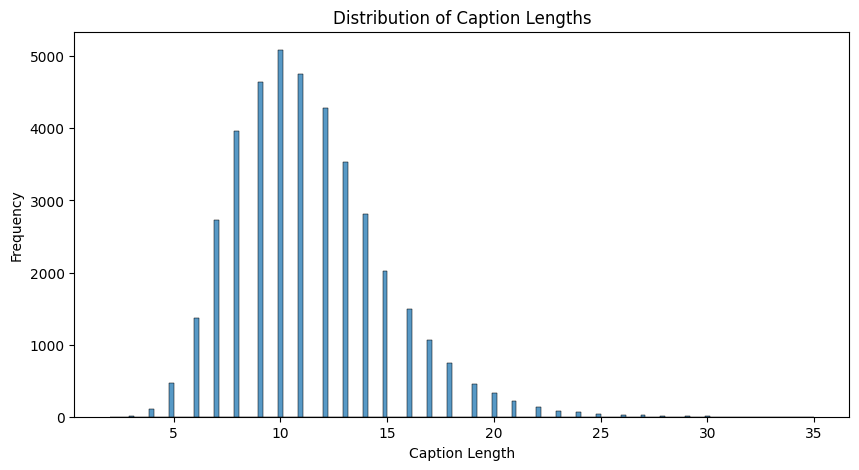

In [10]:
caption_lengths = [len(c.split()) for captions in mapping.values() for c in captions]

plt.figure(figsize=(10, 5))
sns.histplot(caption_lengths, kde=False)
plt.title('Distribution of Caption Lengths')
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()

In [11]:
vocab_size

8485

In [12]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

image_ids = list(mapping.keys())

# Split the data into training and testing sets
train, test = train_test_split(image_ids, test_size=0.20, random_state=42)


In [14]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, add, Bidirectional, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
# LSTM Model ke hyperparameters
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Enhancing model architecture
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1) 
fe2 = Dense(512, activation='relu')(fe1) 
fe3 = BatchNormalization()(fe2) 

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
#se3 = LSTM(512, return_sequences=True)(se2)
#se3 = Bidirectional(LSTM(512, return_sequences=True))(se2)
se4 = LSTM(512)(se2) 
se5 = BatchNormalization()(se4)

# Decoder model
decoder1 = add([fe3, se5])
decoder2 = Dense(512, activation='relu')(decoder1)
decoder3 = BatchNormalization()(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)


model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
plot_model(model, show_shapes=True)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,
    show_dtype=True,
    show_layer_names=False, to_file='model_cnn_lstm_24.png')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 10
batch_size = 32
steps = len(train) // batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=4,restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=WORKING_DIR + '/best_model_large.keras', 
                                   save_best_only=True, 
                                   monitor='val_loss')
history = []
# Training loop
for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    validation_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    print("Epoch: ", i, " out of ", epochs)
    history.append( model.fit(generator, 
              epochs=1, 
              steps_per_epoch=steps, 
              verbose=1, 
              validation_data=validation_generator, 
              validation_steps=len(test) // batch_size, 
              callbacks=[early_stopping, model_checkpoint]))
    
    if ((i>=10 and i%10==0) or i==4):
        model.save(WORKING_DIR+'/model_large2_'+ str(i) + '.keras')        

In [18]:
loss = [item.history['loss'] for item in history]
val_loss = [item.history['val_loss'] for item in history]

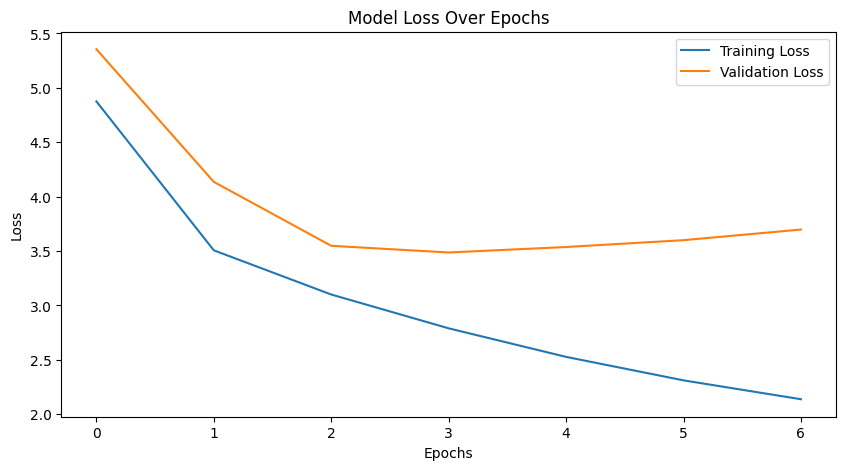

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss elbow.png')
plt.show()

In [20]:
# save the model
model.save(WORKING_DIR+'/model_cnn_lstm_24.keras')

## Generate Captions for the Image

In [56]:
vgg_model = VGG19()
# # restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [55]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [54]:
model = tf.keras.models.load_model("/kaggle/working/model_cnn_lstm_24.keras")

In [57]:
from tensorflow.keras.models import load_model
from PIL import Image

# Load the trained model
#model_path = os.path.join("/kaggle/input/keras-model/", 'best_model_large(2).keras')
#model = load_model("/kaggle/input/keras-model/model_large2_70.keras")

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = sample(yhat[0], temperature=0.4)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    in_text = in_text.replace('startseq', "")
    in_text = in_text.replace('endseq', "")
    return in_text

## testing on images in URL list

In [53]:
url_lst = ['http://farm1.staticflickr.com/19/99088840_7b8197aae8_z.jpg','http://images.cocodataset.org/val2017/000000153299.jpg','https://houstoncriminalfirm.com/wp-content/uploads/2019/06/Canva-_-Theft-900x600.jpg', 'https://ichef.bbci.co.uk/images/ic/1920x1080/p04twqtl.jpg']

In [50]:
import requests
import io
max_length =35

In [49]:
def img_preprocess(url):
  r = requests.get(url, stream=True)
  aux_im = Image.open(io.BytesIO(r.content))
  return aux_im

  0%|          | 0/4 [00:00<?, ?it/s]

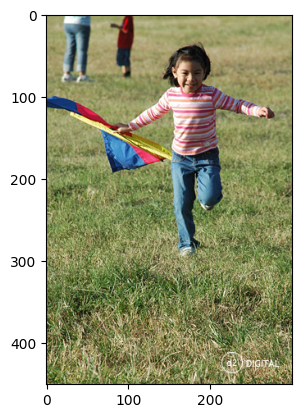

Generated Caption:  young girl in pink and pink outfit jumping over soccer ball 


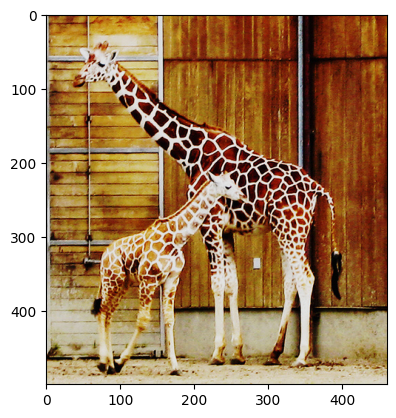

Generated Caption:  brown and white dog is running along the dirt road 


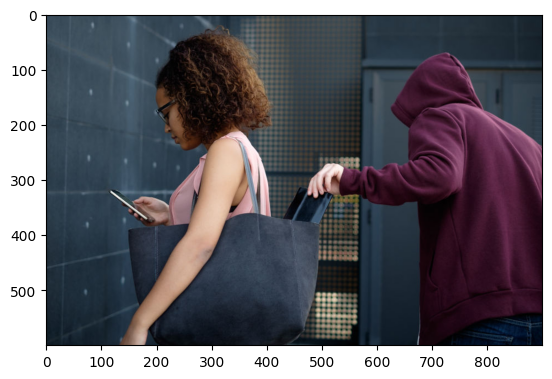

Generated Caption:  man wearing black shirt is standing in front of wall with his hands 


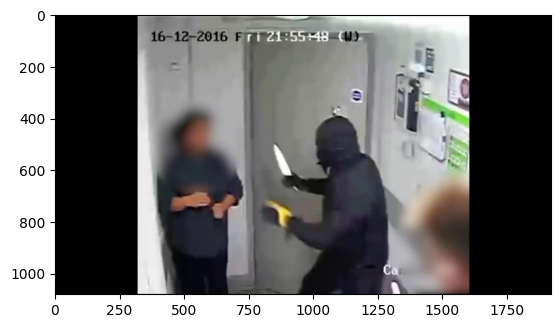

Generated Caption:  man wearing glasses is standing on the street 


In [58]:
for item in tqdm(url_lst):
    image = img_preprocess(item)
    plt.imshow(image)
    plt.show()
    resized_image = image.resize((224, 224))
    image = img_to_array(resized_image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # # preprocess image for vgg
    image = preprocess_input(image)
    # # extract features
    feature = vgg_model.predict(image, verbose=0)
    # # predict from the trained model
    caption = predict_caption(model, feature, tokenizer, max_length) 
    print("Generated Caption:",caption) 


## Tesing on flickr dataset

In [ ]:
def test_an_image(image_id):
    #img_path = BASE_DIR+"flickr8k/Images/"+str(image_id)+".jpg"
    img_path = "/kaggle/input/girl-throw/Capture.jpg"
    if exists(img_path):
    # image = load_img("/kaggle/input/flickr8k/Images/"+sample_image_id+".jpg", target_size=(224, 224))
        image = Image.open(img_path)
        plt.imshow(image)
        sample_feature = features[image_id]
        predicted_caption = predict_caption(model, sample_feature, tokenizer, max_length)
        print("Predicted Caption:", predicted_caption)
    else:
        print("File does not exist: ", img_path)

In [ ]:
image_id = test[5]

test_an_image(image_id)

## EVALUATION using BLEU score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
# validate with test data
actual, predicted = list(), list()
individual_bleu_scores = []

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    score = sentence_bleu(actual_captions, y_pred, weights=(1.0, 0, 0, 0))
    individual_bleu_scores.append(score)

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(individual_bleu_scores, bins=30, kde=True)
plt.title('Distribution of Individual BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.savefig('blue.png')
plt.show()

In [ ]:
# # calcuate BLEU score
# bleu_scores = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
# print("BLEU-1: %f" % bleu_score)
# bleu_scores_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
# print("BLEU-2: %f" % bleu_score_2)
bleu_scores_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
print("BLEU-1: %f" % bleu_scores_1)
bleu_scores_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
print("BLEU-2: %f" % bleu_scores_2)

## Visualize the Results

In [ ]:
# from PIL import Image
# import matplotlib.pyplot as plt
# def generate_caption(image_name):
#     # load the image
#     # image_name = "1001773457_577c3a7d70.jpg"
#     image_id = image_name.split('.')[0]
#     img_path = os.path.join(BASE_DIR, "Images", image_name)
#     image = Image.open(img_path)
#     captions = mapping[image_id]
#     print('---------------------Actual---------------------')
#     for caption in captions:
#         print(caption)
# #     predict the caption
#     y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
#     print('--------------------Predicted--------------------')
#     print(y_pred)
# #     plt.imshow(image)

In [ ]:
# incorrect = []
# correct = []
# for i in range(len(list(features.keys()))):
#     sample_image_id = list(features.keys())[i]  # Replace with your desired image ID
#     sample_feature = features[sample_image_id]
#     try:
#         plt.imshow(sample_image_id+".jpg")
#         cap = predict_caption(model, sample_feature, tokenizer, max_length)
# #         print(generate_caption(features[list(features.keys())[i]]))
#         print(cap)
#         correct.append(list(features.keys())[i])
#     except Exception:
#         incorrect.append(list(features.keys())[i])
#         print("Error", Exception.__str__)

In [ ]:
# correct

In [ ]:
# features.keys()

In [ ]:
# generate_caption("1002674143_1b742ab4b8.jpg")

In [ ]:
# generate_caption("101669240_b2d3e7f17b.jpg")

## Test with Real Image

'startseq two young girls are playing with ball endseq'

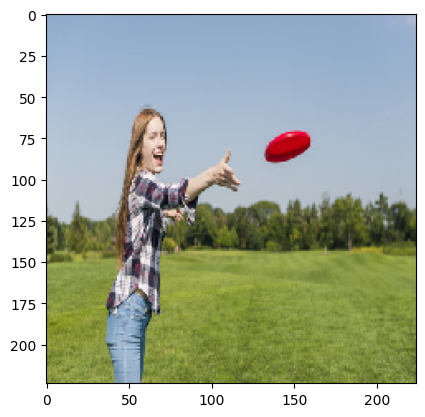

In [25]:
image_path = '/kaggle/input/girl-throw/Capture.jpg'
# # load image
image = load_img(image_path, target_size=(224, 224))
plt.imshow(image)
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# # preprocess image for vgg
image = preprocess_input(image)
# # extract features
feature = vgg_model.predict(image, verbose=0)
# # predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

In [ ]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [ ]:
# # train the model
# epochs = 64
# batch_size = 64
# steps = len(train) // batch_size

# for i in range(epochs):
#     # create data generator
#     generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     # fit for one epoch
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, add
# from tensorflow.keras.optimizers import Adam
# from transformers import TFBertModel, BertConfig

# # Load pre-trained BERT model
# bert_config = BertConfig()  # You might want to adjust the configuration to your needs
# bert_model = TFBertModel(bert_config)

# # Hyperparameters
# learning_rate = 0.001
# vocab_size = len(tokenizer.word_index) + 1  # Assuming tokenizer is already defined
# max_length = 35  # Assuming max length is already defined

# # Adjusting model hyperparameters
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# # Enhancing model architecture
# # Image feature extractor model
# inputs1 = Input(shape=(4096,))
# fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(512, activation='relu')(fe1)
# fe3 = BatchNormalization()(fe2)

# # Transformer model for text
# inputs2 = Input(shape=(max_length,), dtype=tf.int32)
# # Extract embeddings from the transformer
# bert_output = bert_model(inputs2)[0]  # Using last hidden state from BERT
# # You might add additional layers here depending on your needs

# # Decoder model
# # Combining the outputs from image feature extractor and transformer
# decoder1 = add([fe3, bert_output])
# decoder2 = Dense(512, activation='relu')(decoder1)
# decoder3 = BatchNormalization()(decoder2)
# outputs = Dense(vocab_size, activation='softmax')(decoder3)

# # Compile the model
# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# # Plot model (optional)
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# # Feature extractor model
# inputs1 = Input(shape=(4096,))
# fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(512, activation='relu')(fe1)
# fe3 = BatchNormalization()(fe2)  # Adding Batch Normalization

# # Sequence model
# inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
# se2 = Dropout(0.5)(se1)
# se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)  # Using Bidirectional LSTM
# se4 = LSTM(256)(se3)  # Additional LSTM layer
# se5 = BatchNormalization()(se4)  # Adding Batch Normalization

# # Decoder model
# decoder1 = add([fe3, se5])
# decoder2 = Dense(512, activation='relu')(decoder1)
# decoder3 = BatchNormalization()(decoder2)  # Adding Batch Normalization
# outputs = Dense(vocab_size, activation='softmax')(decoder3)

# # Compile model
# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# optimizer = Adam(learning_rate=0.001)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer)
# plot_model(model, show_shapes=True)

In [ ]:
# import os
# from tqdm import tqdm
# # from keras.preprocessing.image import load_img, img_to_array, preprocess_input

# def extract_features_single_image(image_path, model):
#     # load the image from file
#     image = load_img(image_path, target_size=(224, 224))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for model
#     image = preprocess_input(image)
#     # extract features
#     features = model.predict(image, verbose=0)
#     return features

# # Example usage:
# features = extract_features_single_image(os.path.join(BASE_DIR, 'flickr8k/Images', "1002674143_1b742ab4b8.jpg"), vgg_model)